In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
from pylab import cm
import json

import os
import sys
import re
import sympy
from datetime import datetime

import cmath
import matplotlib.patches as patches
from matplotlib import colors as m2colors

import plotly
import plotly.graph_objects as go

from MMfxns import *
from MMdyn import *
from MMplotting import *
from pyDOE2 import lhs

cwd = os.getcwd()
sns.set(style="ticks", font_scale=1.5)

mcolors = dict(m2colors.BASE_COLORS, **m2colors.CSS4_COLORS)

saveall = False
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 


# Figure 1 Stiffness Dependence of Rates

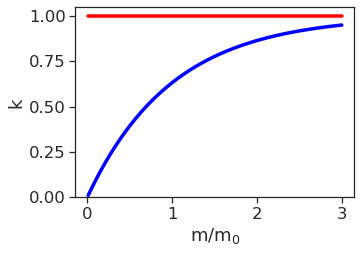

In [2]:
## figure 1
def plot_rates(params, ax=None):
    Nt = 500; 
    m = np.linspace(0.01,3,Nt); 
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(5,3.5))
    
    params['type'] = params['kc']
    kcplot = f_m(m, params)
    ax.plot(m/params['m0'], kcplot, color = 'red', linewidth=3.5, label='kc')

    params['type'] = params['km']
    kmplot = f_m(m, params)
    ax.plot(m/params['m0'], kmplot, color = 'blue', linewidth=3.5, label='km')

#     ax.plot(m/params['m0'], kcplot + kmplot, color = 'green', linewidth=3.5, label='')

#     ax.plot([1., 1.], ax.get_ylim(), color = 'k', linestyle = '-.', linewidth=0.)
    ax.set_xlabel('m/m$_{0}$'); ax.set_ylabel('k')
    ax.set_ylim([0, ax.get_ylim()[1]])
    
    return fig, ax

params = {}
params['kc'] = 1. #'-stiff'
params['km'] = 'stiff'
params['m0'] = 1.

fig, ax = plot_rates(params)

saveall = False
if saveall:
    direc = os.getcwd() + '/figures/figure1/'
#     direc = os.getcwd() + '/powerpoints/ppt_figs/'
    fname1 = direc + "stiff_only_activations_rect_v2.png"
    print(fname1)
    fig.savefig(fname1, format='png', dpi=600)


# Figure 2 Generate Data

In [9]:
## figure 2 data cell
params = {}
params['kc'] = 1.3 # 0.5 #'soft' 1.
params['km'] = 1. # 'stiff'
params['n'] = 5
params['m0'] = 3.
params['x0'] = 2.; 
params['a0'] = 1.; params['xtt'] = 0.
params['x_c'] = x_crit(params['n'])
params['g'] = 10
res = 150

m_space = np.linspace(0.05, 12., res)
x_space = np.linspace(-4, 12., res)
a_space = np.linspace(0.01, 3., res)
# ac_ind = np.where(np.abs(a_space - a_c) == np.amin(np.abs(a_space-a_c)))[0]

a_c = alpha_crit(m_space, params)
m_c = scipy.optimize.fsolve(m_crit_general, 1.5, args=(params), xtol=1e-10)[0] / params['m0']
params['a_c'] = a_c.tolist(); params['m_c'] = m_c

mc_ind = np.where(np.abs(m_space/ params['m0'] - m_c) == np.amin(np.abs(m_space/ params['m0']-m_c)))[0][0]

# U_data, gmin_overm, b1_overm, b2_overm, inf_overm, capture2minima, capture_mvals, capmax = collect_minima(m_space, x_space, a_space, params)
U_data, gmin_overm, b1_overm, b2_overm, inf_overm, capture2minima, capture_mvals, capmax = collect_minima(m_space, x_space, a_space, params)


/home/ccprice/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.



# Figure 2 Plot Phase Diagram

0.5


ValueError: Axis limits cannot be NaN or Inf

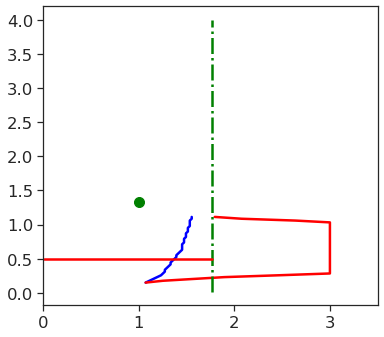

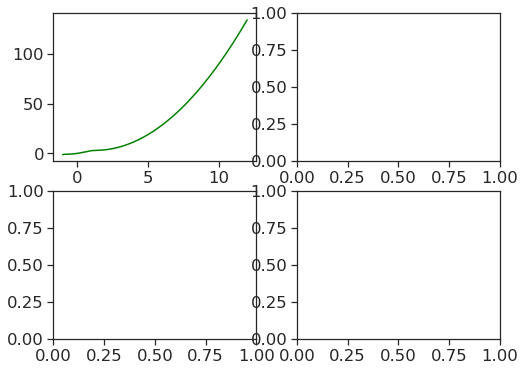

In [10]:
print(params['m_c'])
# print(params['a_c'])
fig, ax = plt.subplots(1,1, figsize=(6, 5.5))

# first order
ax.plot(capture2minima, np.array(capture_mvals) /params['m0'], color='blue', linewidth=2.5)
# first order
ax.plot(capmax, np.array(capture_mvals) /params['m0'], color='red', linewidth=2.5)
# second order
ax.plot(a_c, m_space/params['m0'], color='green', linewidth=2.5, linestyle = '-.')
# second order
ax.plot([np.amin(a_space), a_c[mc_ind]],[m_c, m_c], color='red', linewidth=2.5)
ax.set_xlim([0., 3.5])

gfig = plot_PD_rates(capture2minima, capmax, capture_mvals, m_space, a_space, params)

fig2, ax2 = plt.subplots(2, 2, figsize=(8, 6))

choose_m = [4., 4., 1.3, 1.3] # [1.3, 4., 4., 1.3, 1.3, 2.3]
choose_a = [1., 2.5, 1.5, 2.5] #[1., 1., 2.5, 1.5, 2.5, 2.5]
colors = ['green','red','blue','purple']
for mi, mm in enumerate(choose_m):
#     plotcounter = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2)]
    plotcounter = [(0,0), (0,1), (1,0), (1,1)]
    
    aa = choose_a[mi]    
    ax.scatter(aa, mm/params['m0'], s=100, color=colors[mi])
    gfig.add_trace(go.Scatter(x=[aa], y=[mm/params['m0']],
                    mode='markers', marker=dict(size=20, color=mcolors[colors[mi]]),
                         )
              )
    handle = ax2[plotcounter[mi]]
    
    choose_a_ind = np.where(np.abs(a_space - aa) == np.amin(np.abs(a_space - aa)))[0][0]
    choose_m_ind = np.where(np.abs(m_space - mm) == np.amin(np.abs(m_space - mm)))[0][0]
    
    Uslice = U_data[choose_m_ind, :, :].squeeze()
    m0coordsT = gmin_overm[choose_m_ind]
    m1coordsT = b1_overm[choose_m_ind]
    m2coordsT = b2_overm[choose_m_ind]

    handle.plot(x_space, Uslice[:,choose_a_ind], color=colors[mi]) # mcolors['red']
    xargs = scipy.signal.argrelextrema(Uslice[:,choose_a_ind], np.less)[0]      
    x_mins = x_space[xargs]
    handle.scatter(x_mins, Uslice[xargs, choose_a_ind], s=100, color=colors[mi], zorder=10) # color=mcolors['blueviolet']
    handle.set_ylim([np.amin([np.amin(Uslice[:,choose_a_ind])*1.2,-0.1]), .6])
    handle.set_xlim([0., 2.8])
    handle.set_yticks([])
    for xi, xx in enumerate(x_mins):
        handle.text(0.1, 0.8 - 0.15*xi, ('x$_{n}$=%.2f' % xx), transform=handle.transAxes)

gfig.show()

saveall = False
if saveall:
    now = datetime.now().strftime("%m-%d-%Y_%H.%M")
    
    direc = os.getcwd() + '/../figures_v2/figure2/'
#     direc = os.getcwd() + '/powerpoints/ppt_figs/'
    fname1 = direc + "phase_diagram_rates_v3_"+now+".png"
    fname2 = direc + "phase_diagram_rates_snapshots_v3_"+now+".png"
#     fig.tight_layout()
    fig2.tight_layout()
#     fig.savefig(fname1, format='png', dpi=600)
    fig2.savefig(fname2, format='png', dpi=600)
    gfig.write_image(fname1, scale = 1.5, engine='kaleido')
    with open(fname1 + '.json', 'w') as f:
        f.write(json.dumps(params))

# Figure 2 3D Landscape over Alpha

In [12]:
# 3D plot Udata over alpha
choose_m = 4.5 # m_c
print(m_c)
# have been using 0.4 and 0.6
choose_m_ind = np.where(np.abs(m_space - choose_m) == np.amin(np.abs(m_space-choose_m)))[0][0]
choose_ac = a_c[choose_m_ind]

# x_stiff = 1-np.exp(-choose_m/m0)
ac_ind = np.where(np.abs(a_space - choose_ac) == np.amin(np.abs(a_space - choose_ac)))[0]

Uslice = U_data[choose_m_ind, :, :].squeeze()
bi1_coords = b1_overm[choose_m_ind]
bi2_coords = b2_overm[choose_m_ind]
gmin_coords = gmin_overm[choose_m_ind]

xplot = x_space
aplot = a_space
uplot = Uslice # -U2_data

fig = go.Figure(data=[go.Surface(z=uplot.T, x=xplot, y=aplot, colorscale='blackbody',
                                cmin=np.amin(uplot)*0.8, cmax=np.amax(uplot)/6
                                )],
                     layout = go.Layout(paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
               )

fig.update_traces(contours_z=dict(show=True, usecolormap=False,
                                  project_z=True, start=np.amin(uplot) * 0.9, 
                                  end=np.amax(uplot), color='black', size=0.09))
if len(bi1_coords) > 0:
    
    fig.add_scatter3d(x=bi1_coords[:,0], y=bi1_coords[:,1], z=bi1_coords[:,2]+0.01, mode='markers', showlegend=False,
                      marker=dict(size=4, color='blueviolet'), line=dict(color='blueviolet', width=10))

    fig.add_scatter3d(x=bi2_coords[:,0], y=bi2_coords[:,1], z=bi2_coords[:,2]+0.01, mode='markers', showlegend=False,
                      marker=dict(size=4, color='dodgerblue'), line=dict(color='dodgerblue', width=10))

fig.add_scatter3d(x=gmin_coords[:,0], y=gmin_coords[:,1], z=gmin_coords[:,2]+0.01, mode='markers', showlegend=False,
                  marker=dict(size=4, color='black'), line=dict(color='black', width=10))

## plot inflection point in the second order region
# fig.add_scatter3d(x=inf_coords[:,0], y=inf_coords[:,1], z=inf_coords[:,2]+0.01, mode='markers', showlegend=False,
#                   marker=dict(size=4, color='red'), line=dict(color='red', width=10))

## plot a_c
# fig.add_scatter3d(x=x_space, y=np.ones(res)*choose_ac, z=Uslice[:,ac_ind].squeeze()+0.01, #np.zeros(res),
#                   mode='lines', showlegend=False, line=dict(color='red', width=8))

direc = os.getcwd() + '/../figures_v2/figure2/'
# # direc = os.getcwd() + '/powerpoints/ppt_figs/
now = datetime.now().strftime("%m-%d-%Y_%H.%M")
if choose_m / params['m0'] > m_c:
    fname1 = direc + "XA_memory_eng_surface_overMC"+now+".png"
    titlename = 'Landscape m > m_c'
elif choose_m / params['m0'] < m_c:
    fname1 = direc + "XA_memory_eng_surface_underMC"+now+".png"
    titlename = 'Landscape m < m_c'
elif choose_m / params['m0'] == m_c:
#     fname1 = direc + "XA_memory_eng_surface_atMC.png"
    fname1 = direc + "plain_wadd.png"
    titlename = 'Landscape m = m_c'

fig.update_layout(title=titlename, autosize=True, scene=dict(
                    xaxis = dict(
                        title='<b>x</b>',
#                         title=' ',
                        titlefont=dict(family='Cambria', size=22), 
#                         autorange="reversed", 
#                         showticklabels=False,
                        range=[3., 0.],
                    ),
                    yaxis = dict(
                        title='<b>\u03b1</b>',
#                         title=' ',
                        titlefont=dict(family='Cambria', size=22),
#                         showticklabels=False,
                        range=[0.3, 3.],
                    ), 
                    zaxis = dict(
#                         title='U', 
                        title=' ',
                        range=[np.amin(uplot)*0.8, np.amax(uplot)/6],  
#                         showticklabels=False, titlefont=dict(family='Cambria', size=24)
                    ),
                    aspectmode='cube'),
                  width=1000, height=1000,
                  margin=dict(l=70, r=70, b=70, t=70),
                  font=dict(family='Cambria', size=16, color='#7f7f7f'),
                  
                  scene_camera = {
                'center': {'x': 0, 'y': 0, 'z': 0},
                'eye': {'x': -1.1257999146181883, 'y': 2.2694928492996156, 'z': 0.6797776646344754},
                'projection': {'type': 'perspective'},
                'up': {'x': 0, 'y': 0, 'z': 1}
}
                  )

fig.update_xaxes(title_standoff=50)
fig.update_yaxes(title_standoff=50)

f1 = go.FigureWidget(fig)
display(f1)

saveall = True
if saveall:
    direc = os.getcwd() + '/../figures_v2/figure2/'        
#     direc = os.getcwd() + '/powerpoints/ppt_figs/'
    print(fname1)
    fig.write_image(fname1, scale = 1.5, engine='kaleido')
    

0.8601516567511339


FigureWidget({
    'data': [{'cmax': 8.985663561109881,
              'cmin': -2.530959435542724,
            …

/mnt/b/research/mechanical-memory/cell-mech-memory/../figures_v2/figure2/XA_memory_eng_surface_overMC03-21-2021_20.04.png


In [ ]:
f1.layout.scene.camera

# Figure 2 3D Landscape over M

In [62]:
# 3D plot Udata over m
print(m_c)
choose_a = 2.5
choose_a_ind = np.where(np.abs(a_space - choose_a) == np.amin(np.abs(a_space-choose_a)))[0][0]
# choose_ac = a_c[choose_m_ind]
# ac_ind = np.where(np.abs(a_space - choose_ac) == np.amin(np.abs(a_space - choose_ac)))[0]

Uslice = U_data[:, :, choose_a_ind].squeeze()
mbi1_coords = []; mbi2_coords = []; mgmin_coords = []; minf_coords= [];
for mi, mm in enumerate(m_space / params['m0']):
        
    xargs = scipy.signal.argrelextrema(U_data[mi, :, choose_a_ind], np.less)[0]      
    x_mins = x_space[xargs] 

    if len(x_mins) > 1:
        mbi1_coords.append([np.amin(x_mins), mm, U_data[mi, np.amin(xargs), choose_a_ind]])
        mbi2_coords.append([np.amax(x_mins), mm, U_data[mi, np.amax(xargs), choose_a_ind]])
        
    elif len(x_mins) > 0:
        mgmin_coords.append([x_mins[U_data[mi, xargs, choose_a_ind] == np.amin(U_data[mi, xargs, choose_a_ind])][0],
                             mm, np.amin(U_data[mi, xargs, choose_a_ind])])
#         minf_coords.append([x_mins[U_data[mi, xargs, choose_a_ind] == np.amax(U_data[mi, xargs, choose_a_ind])][0], 
#                             mm, np.amax(U_data[mi, xargs, choose_a_ind])])
    else:
        x_mins = x_space[np.argmin(U_data[mi, :, choose_a_ind])]
        mgmin_coords.append([np.amin(x_mins), mm, U_data[mi, np.argmin(U_data[mi,:,choose_a_ind]), choose_a_ind]])

mbi1_coords = np.array(mbi1_coords)
mbi2_coords = np.array(mbi2_coords)
mgmin_coords = np.array(mgmin_coords)
minf_coords = np.array(minf_coords)

xplot = x_space
mplot = m_space / params['m0']
uplot = Uslice # -U2_data

fig = go.Figure(data=[go.Surface(z=uplot, x=xplot, y=mplot, colorscale='blackbody',
                                cmin=np.amin(uplot)*1.2, cmax=np.amax(uplot)/3
                                )],
                     layout = go.Layout(paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
               )

fig.update_traces(contours_z=dict(show=True, usecolormap=False,
                                  project_z=True, start=np.amin(uplot) * 0.9, 
                                  end=np.amax(uplot), color='black', size=0.09))

if len(mbi1_coords) > 0:
    fig.add_scatter3d(x=mbi1_coords[:,0], y=mbi1_coords[:,1], z=mbi1_coords[:,2]+0.01, mode='markers', showlegend=False,
                      marker=dict(size=4, color='blueviolet'), line=dict(color='blueviolet', width=10))

    fig.add_scatter3d(x=mbi2_coords[:,0], y=mbi2_coords[:,1], z=mbi2_coords[:,2]+0.01, mode='markers', showlegend=False,
                      marker=dict(size=4, color='dodgerblue'), line=dict(color='dodgerblue', width=10))

fig.add_scatter3d(x=mgmin_coords[:,0], y=mgmin_coords[:,1], z=mgmin_coords[:,2]+0.01, mode='markers', showlegend=False,
                  marker=dict(size=4, color='green'), line=dict(color='green', width=10))

# fig.add_scatter3d(x=inf_coords[:,0], y=inf_coords[:,1], z=inf_coords[:,2]+0.01, mode='markers', showlegend=False,
#                   marker=dict(size=4, color='red'), line=dict(color='red', width=10))

# fig.add_scatter3d(x=x_space, y=np.ones(res)*choose_ac, z=Uslice[mc_ind, :].squeeze()+0.01, #np.zeros(res),
#                   mode='lines', showlegend=False, line=dict(color='red', width=8))

direc = os.getcwd() + '/../figures_v2/figure2/'
# # direc = os.getcwd() + '/powerpoints/ppt_figs/'
if choose_a > a_c[choose_a_ind]:
    fname1 = direc + "XA_memory_eng_surface_overAC_bendup.png"
    titlename = 'Landscape a > a_c'
elif choose_a < a_c[choose_a_ind]:
    fname1 = direc + "XA_memory_eng_surface_underAC.png"
    titlename = 'Landscape a < a_c'
elif choose_a == a_c[choose_a_ind]:
    fname1 = direc + "XA_memory_eng_surface_atAC.png"
    titlename = 'Landscape a = a_c'

fig.update_layout(title=titlename, autosize=True, scene=dict(
                    xaxis = dict(
                        title='<b>x</b>',
#                         title=' ',
                        titlefont=dict(family='Cambria', size=22), 
#                         autorange="reversed", 
#                         showticklabels=False,
                        range=[0., 4.],
                    ),
                    yaxis = dict(
                        title='<b>m/m0</b>',
#                         title=' ',
                        titlefont=dict(family='Cambria', size=22),
#                         showticklabels=False,
                        range=[0., 2.],
                    ), 
                    zaxis = dict(
#                         title='U', 
                        title=' ',
                        range=[np.amin(uplot)*1.2, np.amax(uplot)/6],  
#                         showticklabels=False, titlefont=dict(family='Cambria', size=24)
                    ),
                    aspectmode='cube'),
                  width=1000, height=1000,
                  margin=dict(l=70, r=70, b=70, t=70),
                  font=dict(family='Cambria', size=16, color='#7f7f7f'),
                  
                  scene_camera = {
            'center': {'x': 0, 'y': 0, 'z': 0},
            'eye': {'x': 0.5428878983312541, 'y': -1.8893492457586798, 'z': 1.2229604071255062},
            'projection': {'type': 'perspective'},
            'up': {'x': 0, 'y': 0, 'z': 1}
        }
                  )

new_cmin = uplot[(mplot > fig.layout.scene.yaxis.range[0]) & (mplot < fig.layout.scene.yaxis.range[1]),:]
new_cmin = new_cmin[:,(xplot > fig.layout.scene.xaxis.range[0]) & (xplot < fig.layout.scene.xaxis.range[1])]
new_cmax = np.amax(new_cmin)
new_cmin = np.amin(new_cmin)
fig.data[0].cmin = new_cmin
fig.data[0].cmax = new_cmax

fig.update_xaxes(title_standoff=50)
fig.update_yaxes(title_standoff=50)

f2 = go.FigureWidget(fig)
display(f2)

saveall = True
if saveall:
#     direc = os.getcwd() + '/figures/figure2/'        
#     direc = os.getcwd() + '/powerpoints/ppt_figs/'
    print(fname1)
    fname2 = fname1.split('.')[0] + '_secondary.png'
    fig.write_image(fname1, scale = 1.5, engine='kaleido')
#     figR.write_image(fname1.split('.')[0]+'_right.png', scale = 1.5, engine='kaleido' )
#     fig2.savefig(fname2, format='png', dpi=600)

0.8987968575955837
-0.46761788172495455
5.18198586274015


FigureWidget({
    'data': [{'cmax': 5.18198586274015,
              'cmin': -0.46761788172495455,
           …

/mnt/b/research/mechanical-memory/cell-mech-memory/../figures_v2/figure2/XA_memory_eng_surface_underAC.png


In [20]:
f2.layout.scene.camera

layout.scene.Camera({
    'center': {'x': 0, 'y': 0, 'z': 0},
    'eye': {'x': 0.5428878983312541, 'y': -1.8893492457586798, 'z': 1.2229604071255062},
    'projection': {'type': 'perspective'},
    'up': {'x': 0, 'y': 0, 'z': 1}
})

# Figure 3 plot dynamics examples

In [ ]:
## figure 3 dynamics examples

params = {}
params['tau_SGR'] = 120 # params['tau_SG'] #* 2
params['TV0SR'] = 0.03
params['TV0SG'] = .5
params['a0'] = 1.
params['tau_SG'] = 120
params['tau_SR'] = 120
params['a_c'] = 2.3

res = 480

figdim = (5,5)

fig, fig2, ax, ax2 = plotwrap(params, res, figdim)

saveall = False
if saveall:
    
    ax[0].get_yaxis().set_ticks([])
    ax[1].get_yaxis().set_ticks([])
    ax2[0].get_yaxis().set_ticks([])
    ax2[1].get_yaxis().set_ticks([])
    
    direc = os.getcwd() + '/../figures_v2/figure3_timetraj/'
#     direc = os.getcwd() + '/powerpoints/ppt_figs/'

    fname1 = direc + "static_v4_blue.png"
    print(fname1)
    fig.savefig(fname1, format='png', dpi=600)
    
    fname2 = direc + "dynamic_v4_blue.png"
    print(fname2)
    fig2.savefig(fname2, format='png', dpi=600)

In [73]:
### figure 3 background
# params = {}
# # stiff genes
# res = 200
# params = {}
# params['kc'] = 1.
# params['km'] = 'stiff'
# params['n'] = 3
# params['m0'] = 1.
# params['x0'] = 1.; params['a0'] = 0.5; params['xtt'] = 0.;
# params['x_c'] = x_crit(params['n'])

# x_space = np.linspace(0, 3., res)
# a_space = np.linspace(0.2, 3.5, res)
# m_space = np.linspace(0., 3., res)

# a_c = alpha_crit(m_space, params)

gfig = plot_PD_rates(capture2minima, capmax, capture_mvals, m_space, a_space, params)

gfig.show()
saveall=True
if saveall:
    direc = os.getcwd() + '/../figures_v2/figure3_timetraj/'

    fname1 = direc + "blank_PD_rates_v1.png"
    print(fname1)
#     fig.savefig(fname1, format='png', dpi=600)
    gfig.write_image(fname1, scale = 1.5, engine='kaleido')

/mnt/b/research/mechanical-memory/cell-mech-memory/../figures_v2/figure3_timetraj/blank_PD_rates_v1.png


In [ ]:
tau = 1.
tau_F = tau * 5
tau_SG = tau * 178
# tau_SR = tau_SG

m0 = 1.
x0 = 0.2
a0 = 0.2
n = 3

x_c = x_crit(n)
a_c = alpha_crit(n, tau)

ac_test = np.linspace(a_c, a_c*2, 100)

params = {}
params['x_c'] = x_c; params['a_c'] = a_c; params['type'] = 'stiff'; params['m0'] = m0
params['tau'] = tau; params['n'] = n
mc_list = []
for ai, aa in enumerate(ac_test):
    params['a_c'] = aa
    m_c = scipy.optimize.fsolve(m_crit_general, 0.5, args=(params), xtol=1e-10)[0] / params['m0']
    mc_list.append(m_c)

params['m_c'] = m_c
print('a_c = %f, x_c = %f, m_c in absolute = %f' % (a_c, x_c, m_c * params['m0']))

plt.plot(ac_test, mc_list)

In [ ]:
### **** need to shift functions for alpha / regions for alpha depending on stiffness **** ###
### figure 3.5 partially filled phase diagram, no trajectory.
#### integrate profile depends on energy
## setting time units to hours

tau = 1.
tau_F = tau * 15
tau_SG = tau * 150
tau_SR = tau_SG

m0 = 2.
x0 = 0.2
a0 = 0.2
a_max = 100
n = 3

x_c = x_crit(n)
a_c = alpha_crit(n, tau)


params = {}
params['x_c'] = x_c; params['a_c'] = a_c;
params['tau'] = tau; params['tau_F'] = tau_F; params['tau_SG'] = tau_SG; params['tau_SR'] = tau_SR
params['a_max'] = a_max
params['a0'] = a0; params['m0'] = m0
params['n'] = n
params['x0'] = x0
params['x0'] = 1.; params['a0'] = 0.5; params['xtt'] = 0.;
params['type'] = 'stiff'

params['tau_R0'] = tau_SG * 2
params['TV0'] = .08

a_space, mtst = calc_PD(params)

params['a1max'] = a_space[mtst[:,0] == np.amin(mtst[:,0])]

m_c = scipy.optimize.fsolve(m_crit_general, 0.5, args=(params), xtol=1e-10)[0] / params['m0']
params['m_c'] = m_c

print('a_c = %f, x_c = %f, m_c = %f' % (a_c, x_c, m_c))

# 480 hours = 20 days
# time in hours | # stiffness
ins = np.array(
    [
        [250, 0.8],
        [150, 1.6],
#         [250, 0.6],
#         [150, 0.3],    
    ]
        )

m_profile = build_mprof(ins, 1.)

print(np.sum(ins[:,0]))
print(len(m_profile))

# hours
t_space = np.linspace(0, np.sum(ins[:,0]), len(m_profile))
print('dt = %f' % (t_space[1]-t_space[0]))

# x_prof, alpha_prof, params, active_region, deltaVlist = integrate_profile_Edependent(m_profile, t_space, params)
# priming_times, memory_times, mech_ratio = summary_stats(alpha_prof, x_prof, m_profile, t_space, params)
# params, fig, fig2 = plot_profile(t_space, m_profile, x_prof, alpha_prof, active_region, params)
fig, ax = plt.subplots(1,1,figsize=(9, 8))
ax = subplot_PD(ax, params, 
    [mcolors['darkorange'], mcolors['red'], mcolors['navy'], mcolors['navy'], mcolors['springgreen'], mcolors['springgreen']])


# plt.plot(np.arange(len(deltaVlist)), deltaVlist)
saveall = False
if saveall:
    direc = os.getcwd() + '/figures/figure3_timetraj/'

    fname1 = direc + "PD_notrajectory_stiff_n3_v3.png"
    print(fname1)
    fig.savefig(fname1, format='png', dpi=600)


In [ ]:
import sympy

print(sympy.__version__)
sympy.init_printing(use_unicode=True)

n_test = 4
tau = 1.5

a_c = alpha_crit(n_test, tau)
print('a_c %f' % (a_c))

a_test = 5.5

alpha, x, n = sympy.symbols('alpha x n')
eqn = sympy.Eq(1+x**n, sympy.sqrt(alpha * tau * n * x**(n-1)))

eqn = eqn.subs(n, n_test)
eqn = eqn.subs(alpha, a_test)

sol2 = sympy.solve(eqn, x, force=True)

print(sol2)
print(m1n3(a_test, 3))
print(m2n3(a_test, 3))
# print(sol2.evalf())
# print(list(sol2))

x_space = np.linspace(0,2,5000)

solcands = 1+x_space**n_test - np.sqrt(n_test * a_test * tau * x_space**(n_test-1))
roots = np.array(sorted(x_space[np.argpartition(np.abs(solcands),1)][0:2]))
print(roots)
m_roots = -np.log(1 - roots / tau + a_test * roots**n_test / (1+roots**n_test))
print(m_roots)

plt.plot(x_space, solcands)
plt.plot(plt.xlim(), [0,0])

plt.show()

# sol = sympy.solveset(Eq(x**2-n*x, n))
# print(sol)
# print(sol2.subs(alpha, 1.))
# print(sympy.N(sol))
